In [1]:
import numpy as np
import time
import cv2
# from kalman_filter.EKF import ExtendedKalmanFilter
# from kalman_filter.kalman import kalman_filter
import dependencies.constants_robot as cst
import matplotlib.pyplot as plt
from kalman_filter.Filter_class import ExtendedKalmanFilter
from kalman_filter.Filter_func import kalman_func

In [2]:
def f(x, dt):
    angle = x[2]
    dcosA = dt*np.cos(angle)
    dsinA = dt*np.sin(angle)

    f = np.array([
                    [      1,       0,     0, 0, 0],
                    [      0,       1,     0, 0, 0],
                    [      0,       0,     1, 0, 0],
                    [dcosA/2, dsinA/2,  dt/cst.L, 1, 0],
                    [dcosA/2, dsinA/2, -dt/cst.L, 0, 1]])
    
    x_update = x @ f
    return x_update

In [3]:
x_ini = np.array([0, 0, 0, 0, 0])
dt = 0.1
left_wheel =  np.concatenate(([30]*10, [30]*10, [15]*10, [30]*10))
right_wheel = np.concatenate(([30]*10, [15]*10, [30]*10, [30]*10))

In [4]:
position = np.zeros((len(left_wheel), 3))
x_update = x_ini
for i in range(len(left_wheel)-1):
    x_current = x_update
    x_current[3] = left_wheel[i] /3
    x_current[4] = right_wheel[i]/3
    x_update = f(x_current, dt)
    position[i+1] = x_update[0:3]

In [5]:
# simulate noises on the position
position_wheel_noisy = position.copy()
left_wheel_noisy = left_wheel + np.random.normal(0, 0.01, len(left_wheel))
right_wheel_noisy = right_wheel + np.random.normal(0, 0.01, len(left_wheel))
x_update = x_ini
for i in range(len(left_wheel)-1):
    x_current = x_update
    x_current[3] = left_wheel_noisy[i]/3
    x_current[4] = right_wheel_noisy[i]/3
    x_update = f(x_current, dt)
    position_wheel_noisy[i+1] = x_update[0:3]

In [6]:
# do the kalman filter
position_noisy = position.copy()
position_noisy[1:, 0] += np.random.normal(0, 0.01, len(left_wheel)-1)
position_noisy[1:, 1] += np.random.normal(0, 0.01, len(left_wheel)-1)
position_filtered = np.zeros((len(left_wheel), 3))
ekf = ExtendedKalmanFilter(x_ini[0:3])
for i in range(len(left_wheel)):
    if i > 17:
        x_update, x_variance, kidnapping = kalman_func(ekf, None, np.array([left_wheel_noisy[i], right_wheel_noisy[i]]), dt=0.1)
        # x_update, kidnapping = kalman_filter(ekf, None,np.array([left_wheel_noisy[i], right_wheel_noisy[i]]), dt=0.1)
    else:
        x_update, x_variance, kidnapping = kalman_func(ekf, position_noisy[i], np.array([left_wheel_noisy[i], right_wheel_noisy[i]]), dt=0.1)
        # x_update, kidnapping = kalman_filter(ekf, position_noisy[i],np.array([left_wheel_noisy[i], right_wheel_noisy[i]]), dt=0.1)
    position_filtered[i] = x_update[0:3]
    # x_update, kidnapping = kalman_filter(ekf, None,np.array([left_wheel_noisy[i], right_wheel_noisy[i]]), dt=0.1)
    # position_filtered[i] = x_update[0:3]
    

predicted state [0. 0. 0.]
predicted state [9.16865565e-01 8.45648832e-09 5.16674166e-07]
predicted state [1.97821231e+00 5.21094559e-03 7.92431435e-06]
predicted state [ 3.00141769e+00 -4.66417306e-03 -2.49424167e-06]
predicted state [ 4.00622450e+00 -2.12082924e-03 -7.71108380e-07]
predicted state [ 4.99973619e+00 -2.01448480e-03 -5.02495919e-06]
predicted state [6.00514740e+00 1.44211484e-03 6.89043307e-06]
predicted state [ 7.00106877e+00 -3.35670896e-07  5.73732375e-07]
predicted state [ 7.98170806e+00 -4.31201805e-03 -1.34369119e-06]
predicted state [ 8.99684236e+00 -4.02024849e-03 -7.53535673e-06]
predicted state [1.00054984e+01 2.67150027e-03 3.79334236e-06]
predicted state [1.07688270e+01 4.18418613e-04 5.08802542e-03]
predicted state [ 1.15088406e+01 -9.06107295e-03  1.09768760e-02]
predicted state [12.24694551  0.020625    0.01664192]
predicted state [13.00778019  0.02102924  0.02221441]
predicted state [13.76573789  0.03579157  0.02777118]
predicted state [14.50997896  0.06

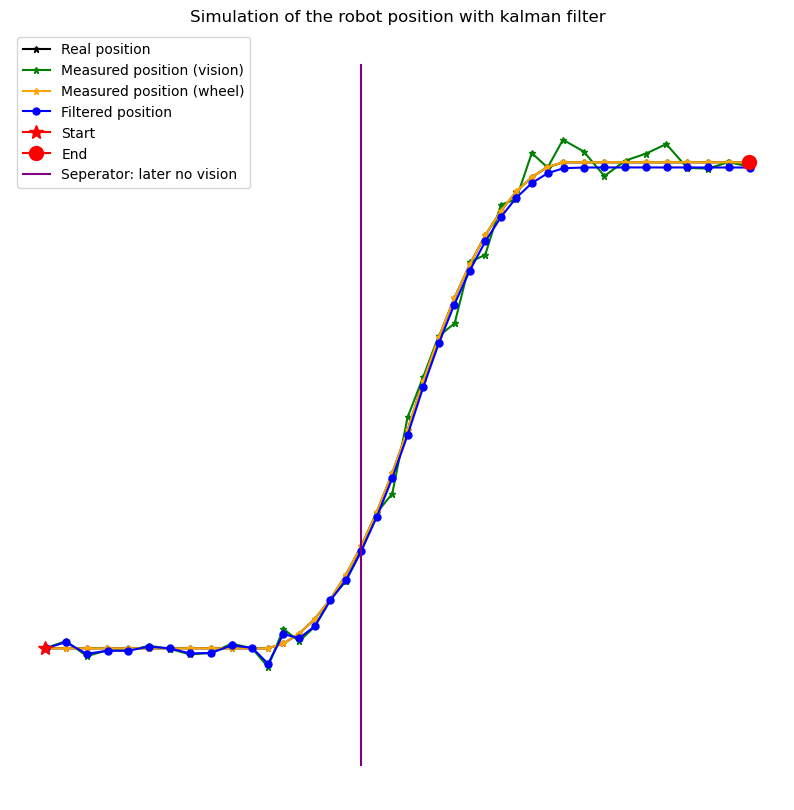

In [7]:
plt.style.use('default')
plt.figure(figsize=(10,10))
plt.plot(position[:,0], position[:,1], marker='*', markersize=5, color="black", label="Real position")
plt.plot(position_noisy[:,0], position_noisy[:,1], marker='*', markersize=5, color="green", label="Measured position (vision)")
plt.plot(position_wheel_noisy[:,0], position_wheel_noisy[:,1], marker='*', markersize=5, color="orange", label="Measured position (wheel)")
plt.plot(position_filtered[:,0], position_filtered[:,1], marker='o', markersize=5, color="blue", label="Filtered position")
plt.plot(position[0,0], position[0,1], marker='*', markersize=10, color="red", label="Start")
plt.plot(position[-1,0], position[-1,1], marker='o', markersize=10, color="red", label="End")
plt.title("Simulation of the robot position with kalman filter")
# draw a straight line at the 15th point to show the no vision part
plt.plot([position[17,0]]*10, np.linspace(-0.1, 0.5, 10), color="purple", label="Seperator: later no vision")
plt.axis('off')
plt.legend()